# Classification model (do 4 types for comparison to pick the best)

In [1]:
# ============================================================================
# SHIP VOYAGE DELAY PREDICTION - MODEL TRAINING
# Task 1: Classification (IsDelayed) | Task 2: Regression (DelayHours)
# ============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Model libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    # Classification metrics
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    # Regression metrics
    mean_absolute_error, mean_squared_error, r2_score
)

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

print("="*80)
print("🚀 SHIP VOYAGE DELAY PREDICTION - MODEL TRAINING")
print("="*80)
print(f"   Task 1: Classification (4 models)")
print(f"   Task 2: Regression (4 models)")
print(f"   Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🚀 SHIP VOYAGE DELAY PREDICTION - MODEL TRAINING
   Task 1: Classification (4 models)
   Task 2: Regression (4 models)
   Started: 2025-12-24 00:14:06


In [2]:
# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

# Load training and test data
print("\n📂 Loading datasets...")
train_df = pd.read_csv('train_2020_2023.csv', parse_dates=['StartTime', 'EndTime'])
test_df = pd.read_csv('test_2024.csv', parse_dates=['StartTime', 'EndTime'])

print(f"   ✅ Training data: {len(train_df):,} rows, {train_df.shape[1]} columns")
print(f"   ✅ Test data: {len(test_df):,} rows, {test_df.shape[1]} columns")

# Define feature columns (exclude target, IDs, and timestamps)
exclude_cols = [
    # Target variables
    'IsDelayed', 'DelayHours', 'DelayPercentage', 'DurationDifference', 
    # ID and metadata
    'MMSI', 'IMO', 'VesselName', 'StartTime', 'EndTime',
    # Direct leakage features 
    'DurationHours',
    'AverageSpeedKMH',
    'TotalDistanceKM',
    'AverageCOG',
    'ExpectedDuration',
    # Coordinates (prevent grid memorization)
    'StartLatitude',
    'StartLongitude',
    # End position leakage (only known after voyage completes)
    'EndLatitude',
    'EndLongitude',
]

feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"\n📊 Feature columns: {len(feature_cols)}")
print(f"   First 10: {feature_cols[:10]}")

# Prepare datasets
X_train_full = train_df[feature_cols].copy()
y_class_train_full = train_df['IsDelayed'].copy()  # Classification target
y_reg_train_full = train_df['DelayHours'].copy()   # Regression target

X_test = test_df[feature_cols].copy()
y_class_test = test_df['IsDelayed'].copy()
y_reg_test = test_df['DelayHours'].copy()

# Verify route-based features exist
required_cols = ['start_lat_region', 'start_lon_region', 'end_lat_region', 'end_lon_region']
missing_cols = [col for col in required_cols if col not in train_df.columns]

if missing_cols:
    print(f"\n⚠️  ERROR: Missing route region columns: {missing_cols}")
    print("   Please re-run data_integration_supervised.ipynb with updated code")
else:
    print(f"\n✅ Route-based features found: {required_cols}")

# Show new class distribution
print(f"\n📊 Class distribution (30% threshold):")
print(f"   Training:")
print(f"      Not Delayed: {(train_df['IsDelayed']==0).sum():,} ({(train_df['IsDelayed']==0).mean()*100:.1f}%)")
print(f"      Delayed: {(train_df['IsDelayed']==1).sum():,} ({(train_df['IsDelayed']==1).mean()*100:.1f}%)")
print(f"   Test:")
print(f"      Not Delayed: {(test_df['IsDelayed']==0).sum():,} ({(test_df['IsDelayed']==0).mean()*100:.1f}%)")
print(f"      Delayed: {(test_df['IsDelayed']==1).sum():,} ({(test_df['IsDelayed']==1).mean()*100:.1f}%)")

print(f"\n✅ Data prepared:")
print(f"   Features: {X_train_full.shape[1]}")
print(f"   Train samples: {len(X_train_full):,}")
print(f"   Test samples: {len(X_test):,}")


STEP 1: LOADING DATA

📂 Loading datasets...
   ✅ Training data: 1,308,221 rows, 49 columns
   ✅ Test data: 367,077 rows, 49 columns

📊 Feature columns: 31
   First 10: ['avg_wind_speed', 'max_wind_speed', 'min_wind_speed', 'avg_temp_celsius', 'max_temp_celsius', 'min_temp_celsius', 'avg_pressure_hpa', 'total_precipitation', 'weather_records', 'num_events']

✅ Route-based features found: ['start_lat_region', 'start_lon_region', 'end_lat_region', 'end_lon_region']

📊 Class distribution (30% threshold):
   Training:
      Not Delayed: 975,604 (74.6%)
      Delayed: 332,617 (25.4%)
   Test:
      Not Delayed: 275,022 (74.9%)
      Delayed: 92,055 (25.1%)

✅ Data prepared:
   Features: 31
   Train samples: 1,308,221
   Test samples: 367,077


In [3]:
# ============================================================================
# STEP 2: VALIDATION SPLIT, CLASS WEIGHTS & FEATURE SCALING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: VALIDATION SPLIT, CLASS WEIGHTS & FEATURE SCALING")
print("="*80)

# Split training data into train/validation sets (80/20)
print("\n🔀 Splitting training data into train/validation sets...")
X_train, X_val, y_class_train, y_class_val = train_test_split(
    X_train_full, y_class_train_full, test_size=0.2, random_state=42, stratify=y_class_train_full
)
_, _, y_reg_train, y_reg_val = train_test_split(
    X_train_full, y_reg_train_full, test_size=0.2, random_state=42, stratify=y_class_train_full
)

print(f"   ✅ Train: {len(X_train):,} samples")
print(f"   ✅ Validation: {len(X_val):,} samples")
print(f"   ✅ Test: {len(X_test):,} samples")

# Analyze class imbalance
print(f"\n⚠️  Class imbalance in training set:")
print(f"   Class 0 (Not Delayed): {(y_class_train == 0).sum():,} ({(y_class_train == 0).mean()*100:.1f}%)")
print(f"   Class 1 (Delayed): {(y_class_train == 1).sum():,} ({(y_class_train == 1).mean()*100:.1f}%)")
print(f"   Imbalance ratio: 1:{(y_class_train == 1).sum() / (y_class_train == 0).sum():.1f}")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_class_train),
                                     y=y_class_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n⚙️  Calculated class weights:")
print(f"   Class 0 weight: {class_weight_dict[0]:.2f} (minority - penalize errors heavily)")
print(f"   Class 1 weight: {class_weight_dict[1]:.2f} (majority - penalize errors lightly)")
print(f"   → Models will treat minority class as {class_weight_dict[0]/class_weight_dict[1]:.1f}x more important")


# Feature scaling (REQUIRED for SVM, SVR, Logistic Regression)
print("\n📏 Scaling features using StandardScaler...")
print("   ⚠️  Fitting on training data only to prevent data leakage")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("   ✅ Features scaled")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("   💾 Scaler saved to: scaler.pkl")

print(f"\n✅ Ready for model training!")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Val shape: {X_val_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")


STEP 2: VALIDATION SPLIT, CLASS WEIGHTS & FEATURE SCALING

🔀 Splitting training data into train/validation sets...
   ✅ Train: 1,046,576 samples
   ✅ Validation: 261,645 samples
   ✅ Test: 367,077 samples

⚠️  Class imbalance in training set:
   Class 0 (Not Delayed): 780,483 (74.6%)
   Class 1 (Delayed): 266,093 (25.4%)
   Imbalance ratio: 1:0.3

⚙️  Calculated class weights:
   Class 0 weight: 0.67 (minority - penalize errors heavily)
   Class 1 weight: 1.97 (majority - penalize errors lightly)
   → Models will treat minority class as 0.3x more important

📏 Scaling features using StandardScaler...
   ⚠️  Fitting on training data only to prevent data leakage
   ✅ Features scaled
   💾 Scaler saved to: scaler.pkl

✅ Ready for model training!
   Train shape: (1046576, 31)
   Val shape: (261645, 31)
   Test shape: (367077, 31)


In [4]:
# ============================================================================
# TASK 1: CLASSIFICATION MODELS
# ============================================================================

print("\n" + "="*80)
print("TASK 1: CLASSIFICATION MODELS")
print("="*80)

# Dictionary to store results
classification_results = {}

# ========== MODEL 1: LOGISTIC REGRESSION ==========
print("\n" + "-"*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("-"*80)

print("🔄 Training Logistic Regression...")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_class_train)

# Predictions
lr_val_pred = lr_model.predict(X_val_scaled)
lr_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
lr_results = {
    'model': 'Logistic Regression',
    'val_accuracy': accuracy_score(y_class_val, lr_val_pred),
    'val_precision': precision_score(y_class_val, lr_val_pred),
    'val_recall': recall_score(y_class_val, lr_val_pred),
    'val_f1': f1_score(y_class_val, lr_val_pred),
    'val_roc_auc': roc_auc_score(y_class_val, lr_val_proba),
    'test_accuracy': accuracy_score(y_class_test, lr_test_pred),
    'test_precision': precision_score(y_class_test, lr_test_pred),
    'test_recall': recall_score(y_class_test, lr_test_pred),
    'test_f1': f1_score(y_class_test, lr_test_pred),
    'test_roc_auc': roc_auc_score(y_class_test, lr_test_proba),
}
classification_results['Logistic Regression'] = lr_results

print("✅ Logistic Regression trained!")
print(f"   Validation Accuracy: {lr_results['val_accuracy']:.4f}")
print(f"   Validation F1-Score: {lr_results['val_f1']:.4f}")
print(f"   Validation ROC-AUC: {lr_results['val_roc_auc']:.4f}")

# Save model
with open('model_lr_classification.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# ========== MODEL 2: Linear SVM ==========
print("\n" + "-"*80)
print("MODEL 2: Linear SVM")
print("-"*80)

print("🔄 Training Linear SVM...")
svm_model = LinearSVC(class_weight='balanced', max_iter=1000, random_state=42, dual=False)

# Wrap with calibration to get probability estimates
svm_model = CalibratedClassifierCV(svm_model, cv=3)
svm_model.fit(X_train_scaled, y_class_train)

# Predictions
svm_val_pred = svm_model.predict(X_val_scaled)
svm_val_proba = svm_model.predict_proba(X_val_scaled)[:, 1]
svm_test_pred = svm_model.predict(X_test_scaled)
svm_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
svm_results = {
    'model': 'Linear SVM',
    'val_accuracy': accuracy_score(y_class_val, svm_val_pred),
    'val_precision': precision_score(y_class_val, svm_val_pred),
    'val_recall': recall_score(y_class_val, svm_val_pred),
    'val_f1': f1_score(y_class_val, svm_val_pred),
    'val_roc_auc': roc_auc_score(y_class_val, svm_val_proba),
    'test_accuracy': accuracy_score(y_class_test, svm_test_pred),
    'test_precision': precision_score(y_class_test, svm_test_pred),
    'test_recall': recall_score(y_class_test, svm_test_pred),
    'test_f1': f1_score(y_class_test, svm_test_pred),
    'test_roc_auc': roc_auc_score(y_class_test, svm_test_proba),
}
classification_results['Linear SVM'] = svm_results

print("✅ Linear SVM trained!")
print(f"   Validation Accuracy: {svm_results['val_accuracy']:.4f}")
print(f"   Validation F1-Score: {svm_results['val_f1']:.4f}")
print(f"   Validation ROC-AUC: {svm_results['val_roc_auc']:.4f}")

# Save model
with open('model_svm_classification.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# ========== MODEL 3: RANDOM FOREST ==========
print("\n" + "-"*80)
print("MODEL 3: RANDOM FOREST")
print("-"*80)

print("🔄 Training Random Forest...")
rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50, 
    max_depth=15, 
    min_samples_split=20,
    max_samples=0.7,
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_class_train)

# Predictions
rf_val_pred = rf_model.predict(X_val_scaled)
rf_val_proba = rf_model.predict_proba(X_val_scaled)[:, 1]
rf_test_pred = rf_model.predict(X_test_scaled)
rf_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
rf_results = {
    'model': 'Random Forest',
    'val_accuracy': accuracy_score(y_class_val, rf_val_pred),
    'val_precision': precision_score(y_class_val, rf_val_pred),
    'val_recall': recall_score(y_class_val, rf_val_pred),
    'val_f1': f1_score(y_class_val, rf_val_pred),
    'val_roc_auc': roc_auc_score(y_class_val, rf_val_proba),
    'test_accuracy': accuracy_score(y_class_test, rf_test_pred),
    'test_precision': precision_score(y_class_test, rf_test_pred),
    'test_recall': recall_score(y_class_test, rf_test_pred),
    'test_f1': f1_score(y_class_test, rf_test_pred),
    'test_roc_auc': roc_auc_score(y_class_test, rf_test_proba),
}
classification_results['Random Forest'] = rf_results

print("✅ Random Forest trained!")
print(f"   Validation Accuracy: {rf_results['val_accuracy']:.4f}")
print(f"   Validation F1-Score: {rf_results['val_f1']:.4f}")
print(f"   Validation ROC-AUC: {rf_results['val_roc_auc']:.4f}")

# Save model
with open('model_rf_classification.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\n🔝 Top 10 important features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

# ========== MODEL 4: XGBOOST ==========
print("\n" + "-"*80)
print("MODEL 4: XGBOOST")
print("-"*80)

print("🔄 Training XGBoost...")
xgb_model = XGBClassifier(
    scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_class_train)

# Predictions
xgb_val_pred = xgb_model.predict(X_val_scaled)
xgb_val_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
xgb_test_pred = xgb_model.predict(X_test_scaled)
xgb_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
xgb_results = {
    'model': 'XGBoost',
    'val_accuracy': accuracy_score(y_class_val, xgb_val_pred),
    'val_precision': precision_score(y_class_val, xgb_val_pred),
    'val_recall': recall_score(y_class_val, xgb_val_pred),
    'val_f1': f1_score(y_class_val, xgb_val_pred),
    'val_roc_auc': roc_auc_score(y_class_val, xgb_val_proba),
    'test_accuracy': accuracy_score(y_class_test, xgb_test_pred),
    'test_precision': precision_score(y_class_test, xgb_test_pred),
    'test_recall': recall_score(y_class_test, xgb_test_pred),
    'test_f1': f1_score(y_class_test, xgb_test_pred),
    'test_roc_auc': roc_auc_score(y_class_test, xgb_test_proba),
}
classification_results['XGBoost'] = xgb_results

print("✅ XGBoost trained!")
print(f"   Validation Accuracy: {xgb_results['val_accuracy']:.4f}")
print(f"   Validation F1-Score: {xgb_results['val_f1']:.4f}")
print(f"   Validation ROC-AUC: {xgb_results['val_roc_auc']:.4f}")

# Save model
with open('model_xgb_classification.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 XGBoost Top 10 Features:")
for idx, row in xgb_importance.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

# Highlight route features in importance ranking
print(f"\n🗺️  Route-based features importance:")
route_features = ['start_lat_region', 'start_lon_region', 'end_lat_region', 'end_lon_region']
for feat in route_features:
    if feat in xgb_importance['feature'].values:
        importance = xgb_importance[xgb_importance['feature'] == feat]['importance'].values[0]
        rank = xgb_importance[xgb_importance['feature'] == feat].index[0] + 1
        print(f"   {feat}: {importance:.4f} (Rank #{rank}/{len(xgb_importance)})")

# ========== CLASSIFICATION RESULTS SUMMARY ==========
print("\n" + "="*80)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*80)

results_df = pd.DataFrame(classification_results).T
print("\n📊 VALIDATION SET PERFORMANCE:")
print(results_df[['val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_roc_auc']].to_string())

print("\n📊 TEST SET PERFORMANCE:")
print(results_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']].to_string())

# Save results
results_df.to_csv('classification_results.csv')
print("\n💾 Results saved to: classification_results.csv")

# Find best model
best_model_name = results_df['test_f1'].idxmax()
print(f"\n🏆 BEST CLASSIFICATION MODEL: {best_model_name}")
print(f"   Test F1-Score: {results_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"   Test ROC-AUC: {results_df.loc[best_model_name, 'test_roc_auc']:.4f}")


TASK 1: CLASSIFICATION MODELS

--------------------------------------------------------------------------------
MODEL 1: LOGISTIC REGRESSION
--------------------------------------------------------------------------------
🔄 Training Logistic Regression...
✅ Logistic Regression trained!
   Validation Accuracy: 0.7576
   Validation F1-Score: 0.6138
   Validation ROC-AUC: 0.8378

--------------------------------------------------------------------------------
MODEL 2: Linear SVM
--------------------------------------------------------------------------------
🔄 Training Linear SVM...
✅ Linear SVM trained!
   Validation Accuracy: 0.8093
   Validation F1-Score: 0.5303
   Validation ROC-AUC: 0.8372

--------------------------------------------------------------------------------
MODEL 3: RANDOM FOREST
--------------------------------------------------------------------------------
🔄 Training Random Forest...
✅ Random Forest trained!
   Validation Accuracy: 0.9352
   Validation F1-Score: 0.88


DETAILED CLASSIFICATION ANALYSIS

--------------------------------------------------------------------------------
MODEL: Logistic Regression
--------------------------------------------------------------------------------

📊 Confusion Matrix (Test Set):
                    Predicted
                 NOT DELAYED  DELAYED
Actual NOT DELAYED    201417     73605
       DELAYED         17507     74548

🔍 Confusion Matrix Components:
   True Negatives (TN):  201,417 (correctly predicted NOT delayed)
   False Positives (FP): 73,605 (incorrectly predicted as delayed)
   False Negatives (FN): 17,507 (incorrectly predicted as NOT delayed)
   True Positives (TP):  74,548 (correctly predicted delayed)

📈 Additional Metrics:
   Specificity (TNR):    0.7324 (correct NOT delayed rate)
   Sensitivity (TPR):    0.8098 (correct delayed rate)
   False Positive Rate:  0.2676
   False Negative Rate:  0.1902

⚖️  CLASS BALANCE METRICS (Test Set):

   MICRO-AVERAGED (treats all samples equally):
      Prec

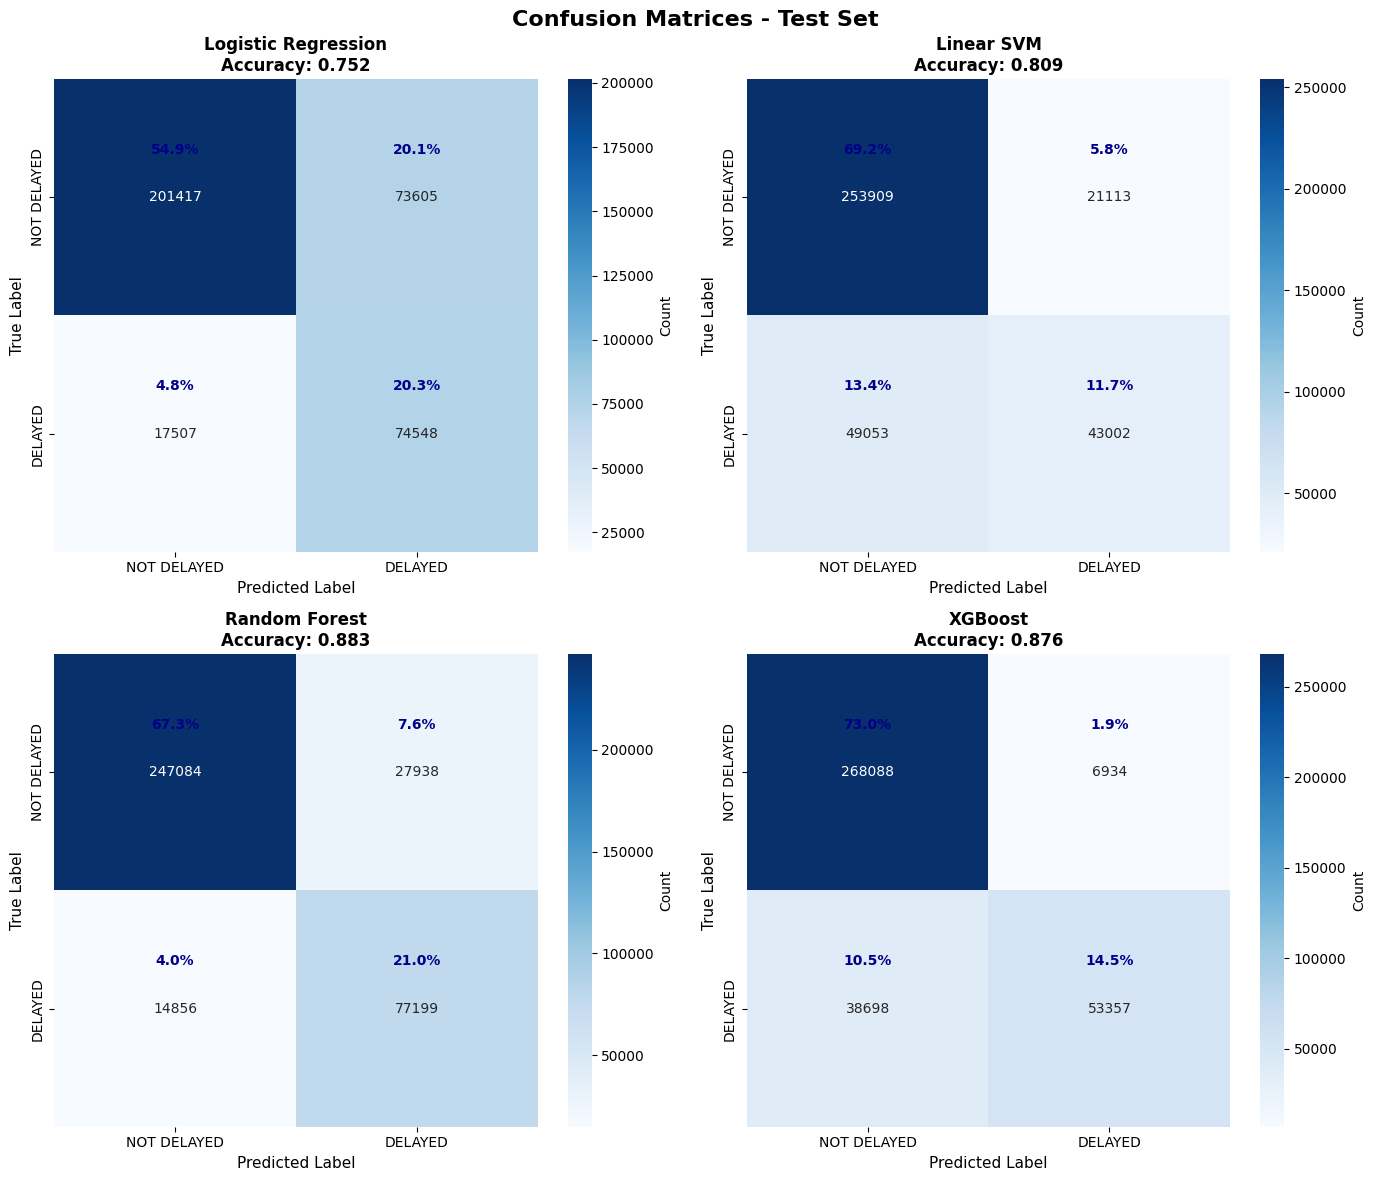

   ✅ Saved: macro_vs_micro_comparison.png


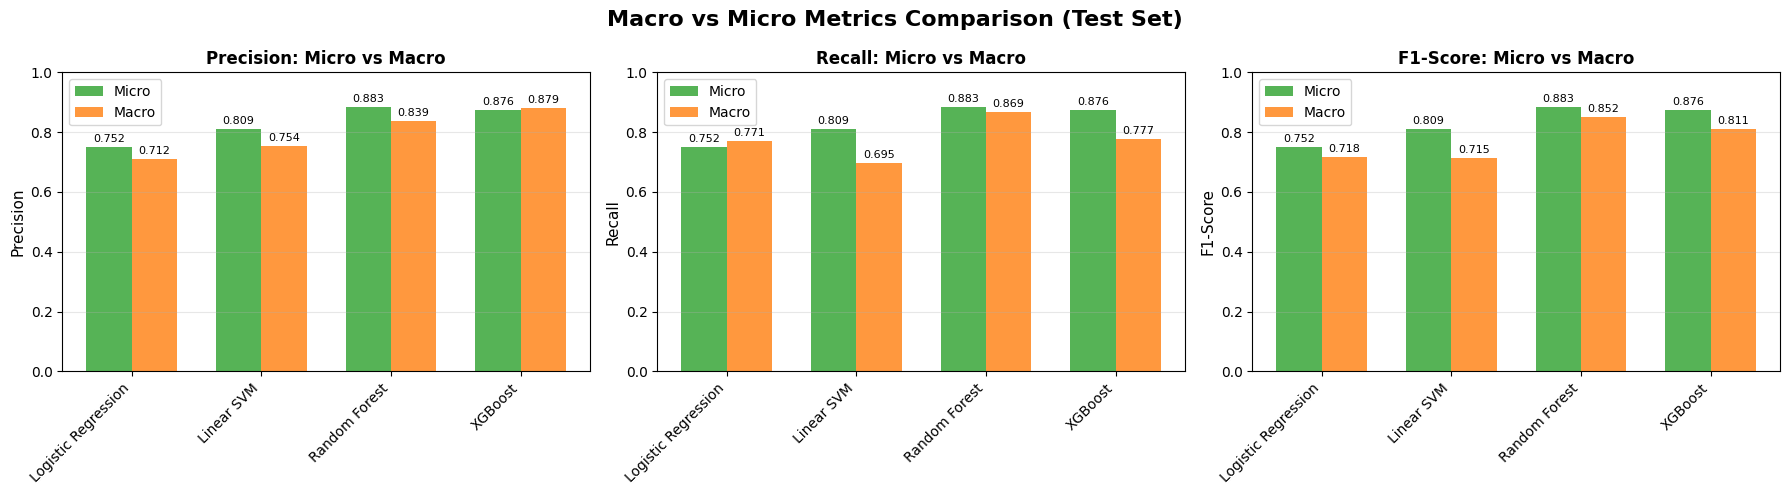

   ✅ Saved: per_class_f1_comparison.png


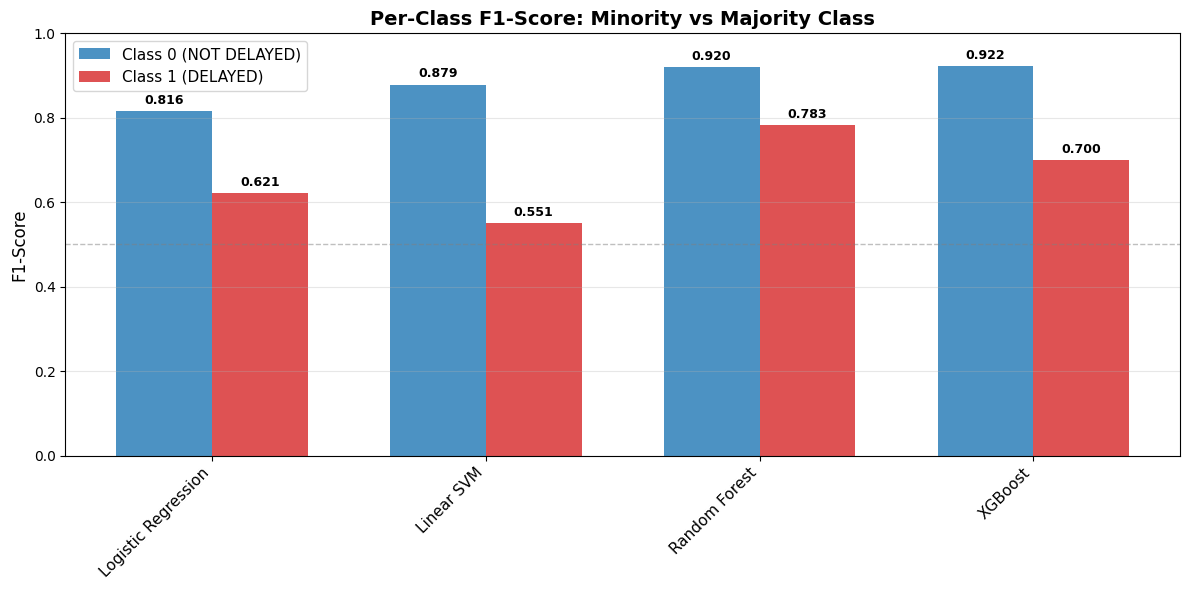


✅ DETAILED CLASSIFICATION ANALYSIS COMPLETED!

💡 INTERPRETATION GUIDE:
   • Micro-averaged: Overall performance across all samples
   • Macro-averaged: Average performance across both classes (equal weight)
   • If Macro < Micro: Model favors majority class
   • If Macro ≈ Micro: Model handles both classes equally well
   • Class 1 (DELAYED) metrics show how well minority class is predicted
   • High TN + TP and low FP + FN = good overall performance


In [5]:
# ============================================================================
# DETAILED CLASSIFICATION ANALYSIS: CONFUSION MATRICES & CLASS BALANCE METRICS
# ============================================================================

print("\n" + "="*80)
print("DETAILED CLASSIFICATION ANALYSIS")
print("="*80)

# Dictionary to store detailed metrics
detailed_results = {}

models = {
    'Logistic Regression': (lr_model, lr_test_pred, lr_test_proba),
    'Linear SVM': (svm_model, svm_test_pred, svm_test_proba),
    'Random Forest': (rf_model, rf_test_pred, rf_test_proba),
    'XGBoost': (xgb_model, xgb_test_pred, xgb_test_proba)
}

for model_name, (model, test_pred, test_proba) in models.items():
    print("\n" + "-"*80)
    print(f"MODEL: {model_name}")
    print("-"*80)
    
    # Confusion Matrix
    cm = confusion_matrix(y_class_test, test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📊 Confusion Matrix (Test Set):")
    print(f"                    Predicted")
    print(f"                 NOT DELAYED  DELAYED")
    print(f"Actual NOT DELAYED    {tn:6d}    {fp:6d}")
    print(f"       DELAYED        {fn:6d}    {tp:6d}")
    
    print(f"\n🔍 Confusion Matrix Components:")
    print(f"   True Negatives (TN):  {tn:,} (correctly predicted NOT delayed)")
    print(f"   False Positives (FP): {fp:,} (incorrectly predicted as delayed)")
    print(f"   False Negatives (FN): {fn:,} (incorrectly predicted as NOT delayed)")
    print(f"   True Positives (TP):  {tp:,} (correctly predicted delayed)")
    
    # Additional metrics
    total = tn + fp + fn + tp
    print(f"\n📈 Additional Metrics:")
    print(f"   Specificity (TNR):    {tn/(tn+fp):.4f} (correct NOT delayed rate)")
    print(f"   Sensitivity (TPR):    {tp/(tp+fn):.4f} (correct delayed rate)")
    print(f"   False Positive Rate:  {fp/(fp+tn):.4f}")
    print(f"   False Negative Rate:  {fn/(fn+tp):.4f}")
    
    # Macro and Micro F1, Precision, Recall
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_micro = precision_score(y_class_test, test_pred, average='micro')
    recall_micro = recall_score(y_class_test, test_pred, average='micro')
    f1_micro = f1_score(y_class_test, test_pred, average='micro')
    
    precision_macro = precision_score(y_class_test, test_pred, average='macro')
    recall_macro = recall_score(y_class_test, test_pred, average='macro')
    f1_macro = f1_score(y_class_test, test_pred, average='macro')
    
    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_class_test, test_pred, average=None
    )
    
    print(f"\n⚖️  CLASS BALANCE METRICS (Test Set):")
    print(f"\n   MICRO-AVERAGED (treats all samples equally):")
    print(f"      Precision: {precision_micro:.4f}")
    print(f"      Recall:    {recall_micro:.4f}")
    print(f"      F1-Score:  {f1_micro:.4f}")
    
    print(f"\n   MACRO-AVERAGED (treats all classes equally):")
    print(f"      Precision: {precision_macro:.4f}")
    print(f"      Recall:    {recall_macro:.4f}")
    print(f"      F1-Score:  {f1_macro:.4f}")
    
    print(f"\n   PER-CLASS METRICS:")
    print(f"      Class 0 (NOT DELAYED):")
    print(f"         Precision: {precision_per_class[0]:.4f} ({tn}/{tn+fp} predictions correct)")
    print(f"         Recall:    {recall_per_class[0]:.4f} ({tn}/{tn+fn} samples found)")
    print(f"         F1-Score:  {f1_per_class[0]:.4f}")
    print(f"         Support:   {support_per_class[0]:,} samples")
    
    print(f"      Class 1 (DELAYED):")
    print(f"         Precision: {precision_per_class[1]:.4f} ({tp}/{tp+fp} predictions correct)")
    print(f"         Recall:    {recall_per_class[1]:.4f} ({tp}/{tp+fn} samples found)")
    print(f"         F1-Score:  {f1_per_class[1]:.4f}")
    print(f"         Support:   {support_per_class[1]:,} samples")
    
    # Class balance assessment
    print(f"\n✅ CLASS IMBALANCE HANDLING ASSESSMENT:")
    minority_recall = recall_per_class[1]  # Recall for delayed class (minority)
    majority_recall = recall_per_class[0]  # Recall for not delayed class (majority)
    
    if minority_recall > 0.5 and majority_recall > 0.5:
        print(f"   ✅ GOOD: Both classes have >50% recall")
        print(f"      Model predicts both delayed and non-delayed voyages")
    elif minority_recall < 0.3:
        print(f"   ⚠️  WARNING: Minority class recall is {minority_recall:.1%}")
        print(f"      Model struggles to predict delayed voyages")
    else:
        print(f"   ⚖️  MODERATE: Minority recall = {minority_recall:.1%}, Majority recall = {majority_recall:.1%}")
    
    # Store detailed metrics
    detailed_results[model_name] = {
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp,
        'Specificity': tn/(tn+fp),
        'Sensitivity': tp/(tp+fn),
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_class0': precision_per_class[0],
        'recall_class0': recall_per_class[0],
        'f1_class0': f1_per_class[0],
        'precision_class1': precision_per_class[1],
        'recall_class1': recall_per_class[1],
        'f1_class1': f1_per_class[1],
    }

# ========== COMPARATIVE SUMMARY TABLE ==========
print("\n" + "="*80)
print("COMPARATIVE SUMMARY: CLASS BALANCE METRICS")
print("="*80)

detailed_df = pd.DataFrame(detailed_results).T

print("\n📊 CONFUSION MATRIX COMPONENTS:")
print(detailed_df[['TN', 'FP', 'FN', 'TP']].to_string())

print("\n📊 MICRO vs MACRO METRICS (Test Set):")
print(detailed_df[['precision_micro', 'precision_macro', 
                   'recall_micro', 'recall_macro',
                   'f1_micro', 'f1_macro']].to_string())

print("\n📊 PER-CLASS PERFORMANCE:")
print("\n   Class 0 (NOT DELAYED):")
print(detailed_df[['precision_class0', 'recall_class0', 'f1_class0']].to_string())

print("\n   Class 1 (DELAYED - MINORITY CLASS):")
print(detailed_df[['precision_class1', 'recall_class1', 'f1_class1']].to_string())

# Save detailed results
detailed_df.to_csv('classification_detailed_metrics.csv')
print("\n💾 Detailed metrics saved to: classification_detailed_metrics.csv")

# ========== VISUALIZATION: CONFUSION MATRICES ==========
print("\n📊 Generating confusion matrix visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - Test Set', fontsize=16, fontweight='bold')

model_list = ['Logistic Regression', 'Linear SVM', 'Random Forest', 'XGBoost']
predictions_list = [lr_test_pred, svm_test_pred, rf_test_pred, xgb_test_pred]

for idx, (model_name, test_pred) in enumerate(zip(model_list, predictions_list)):
    ax = axes[idx // 2, idx % 2]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_class_test, test_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['NOT DELAYED', 'DELAYED'],
                yticklabels=['NOT DELAYED', 'DELAYED'],
                cbar_kws={'label': 'Count'})
    
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_title(f'{model_name}\nAccuracy: {accuracy_score(y_class_test, test_pred):.3f}', 
                 fontsize=12, fontweight='bold')
    
    # Add percentages
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    ax.text(0.5, 0.3, f'{tn/total*100:.1f}%', ha='center', va='center', 
            fontsize=10, color='darkblue', weight='bold')
    ax.text(1.5, 0.3, f'{fp/total*100:.1f}%', ha='center', va='center', 
            fontsize=10, color='darkblue', weight='bold')
    ax.text(0.5, 1.3, f'{fn/total*100:.1f}%', ha='center', va='center', 
            fontsize=10, color='darkblue', weight='bold')
    ax.text(1.5, 1.3, f'{tp/total*100:.1f}%', ha='center', va='center', 
            fontsize=10, color='darkblue', weight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: confusion_matrices.png")
plt.show()

# ========== VISUALIZATION: MACRO vs MICRO COMPARISON ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Macro vs Micro Metrics Comparison (Test Set)', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('precision_micro', 'precision_macro', 'Precision'),
    ('recall_micro', 'recall_macro', 'Recall'),
    ('f1_micro', 'f1_macro', 'F1-Score')
]

x = np.arange(len(model_list))
width = 0.35

for idx, (micro_col, macro_col, metric_name) in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    micro_values = detailed_df[micro_col].values
    macro_values = detailed_df[macro_col].values
    
    bars1 = ax.bar(x - width/2, micro_values, width, label='Micro', color='#2ca02c', alpha=0.8)
    bars2 = ax.bar(x + width/2, macro_values, width, label='Macro', color='#ff7f0e', alpha=0.8)
    
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'{metric_name}: Micro vs Macro', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('macro_vs_micro_comparison.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: macro_vs_micro_comparison.png")
plt.show()

# ========== VISUALIZATION: PER-CLASS F1 SCORES ==========
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_list))
width = 0.35

class0_f1 = detailed_df['f1_class0'].values
class1_f1 = detailed_df['f1_class1'].values

bars1 = ax.bar(x - width/2, class0_f1, width, label='Class 0 (NOT DELAYED)', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, class1_f1, width, label='Class 1 (DELAYED)', color='#d62728', alpha=0.8)

ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score: Minority vs Majority Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_list, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, weight='bold')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, weight='bold')

# Add horizontal line at 0.5 for reference
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.savefig('per_class_f1_comparison.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: per_class_f1_comparison.png")
plt.show()

print("\n" + "="*80)
print("✅ DETAILED CLASSIFICATION ANALYSIS COMPLETED!")
print("="*80)
print("\n💡 INTERPRETATION GUIDE:")
print("   • Micro-averaged: Overall performance across all samples")
print("   • Macro-averaged: Average performance across both classes (equal weight)")
print("   • If Macro < Micro: Model favors majority class")
print("   • If Macro ≈ Micro: Model handles both classes equally well")
print("   • Class 1 (DELAYED) metrics show how well minority class is predicted")
print("   • High TN + TP and low FP + FN = good overall performance")

# Regression model (do 4 types for comparison to pick the best)

In [9]:
# ============================================================================
# TASK 2: REGRESSION - PREDICT DelayHours
# ============================================================================

print("\n" + "="*80)
print("TASK 2: REGRESSION MODELS")
print("="*80)

# Dictionary to store results
regression_results = {}

# ========== MODEL 1: LINEAR REGRESSION ==========
print("\n" + "-"*80)
print("MODEL 1: LINEAR REGRESSION")
print("-"*80)

print("🔄 Training Linear Regression...")
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_train_scaled, y_reg_train)

# Predictions
linreg_val_pred = linreg_model.predict(X_val_scaled)
linreg_test_pred = linreg_model.predict(X_test_scaled)

# Metrics
linreg_results = {
    'model': 'Linear Regression',
    'val_mae': mean_absolute_error(y_reg_val, linreg_val_pred),
    'val_rmse': np.sqrt(mean_squared_error(y_reg_val, linreg_val_pred)),
    'val_r2': r2_score(y_reg_val, linreg_val_pred),
    'test_mae': mean_absolute_error(y_reg_test, linreg_test_pred),
    'test_rmse': np.sqrt(mean_squared_error(y_reg_test, linreg_test_pred)),
    'test_r2': r2_score(y_reg_test, linreg_test_pred),
}
regression_results['Linear Regression'] = linreg_results

print("✅ Linear Regression trained!")
print(f"   Validation MAE: {linreg_results['val_mae']:.4f} hours")
print(f"   Validation RMSE: {linreg_results['val_rmse']:.4f} hours")
print(f"   Validation R²: {linreg_results['val_r2']:.4f}")

# Save model
with open('model_linreg_regression.pkl', 'wb') as f:
    pickle.dump(linreg_model, f)

# ========== MODEL 2: Linear SVR ==========
print("\n" + "-"*80)
print("MODEL 2: LINEAR SUPPORT VECTOR REGRESSION (Linear SVR)")
print("-"*80)

print("🔄 Training Linear SVR...")
svr_model = LinearSVR(max_iter=10000, random_state=42, dual=False, loss='squared_epsilon_insensitive')
svr_model.fit(X_train_scaled, y_reg_train)

# Predictions
svr_val_pred = svr_model.predict(X_val_scaled)
svr_test_pred = svr_model.predict(X_test_scaled)

# Metrics
svr_results = {
    'model': 'Linear SVR',
    'val_mae': mean_absolute_error(y_reg_val, svr_val_pred),
    'val_rmse': np.sqrt(mean_squared_error(y_reg_val, svr_val_pred)),
    'val_r2': r2_score(y_reg_val, svr_val_pred),
    'test_mae': mean_absolute_error(y_reg_test, svr_test_pred),
    'test_rmse': np.sqrt(mean_squared_error(y_reg_test, svr_test_pred)),
    'test_r2': r2_score(y_reg_test, svr_test_pred),
}
regression_results['Linear SVR'] = svr_results

print("✅ Linear SVR trained!")
print(f"   Validation MAE: {svr_results['val_mae']:.4f} hours")
print(f"   Validation RMSE: {svr_results['val_rmse']:.4f} hours")
print(f"   Validation R²: {svr_results['val_r2']:.4f}")

# Save model
with open('model_svr_regression.pkl', 'wb') as f:
    pickle.dump(svr_model, f)

# ========== MODEL 3: RANDOM FOREST ==========
print("\n" + "-"*80)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("-"*80)

print("🔄 Training Random Forest Regressor...")
rfr_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    min_samples_split=20,
    max_samples=0.7,
    random_state=42,
    n_jobs=-1
)
rfr_model.fit(X_train_scaled, y_reg_train)

# Predictions
rfr_val_pred = rfr_model.predict(X_val_scaled)
rfr_test_pred = rfr_model.predict(X_test_scaled)

# Metrics
rfr_results = {
    'model': 'Random Forest',
    'val_mae': mean_absolute_error(y_reg_val, rfr_val_pred),
    'val_rmse': np.sqrt(mean_squared_error(y_reg_val, rfr_val_pred)),
    'val_r2': r2_score(y_reg_val, rfr_val_pred),
    'test_mae': mean_absolute_error(y_reg_test, rfr_test_pred),
    'test_rmse': np.sqrt(mean_squared_error(y_reg_test, rfr_test_pred)),
    'test_r2': r2_score(y_reg_test, rfr_test_pred),
}
regression_results['Random Forest'] = rfr_results

print("✅ Random Forest Regressor trained!")
print(f"   Validation MAE: {rfr_results['val_mae']:.4f} hours")
print(f"   Validation RMSE: {rfr_results['val_rmse']:.4f} hours")
print(f"   Validation R²: {rfr_results['val_r2']:.4f}")

# Save model
with open('model_rfr_regression.pkl', 'wb') as f:
    pickle.dump(rfr_model, f)

# ========== MODEL 4: XGBOOST ==========
print("\n" + "-"*80)
print("MODEL 4: XGBOOST REGRESSOR")
print("-"*80)

print("🔄 Training XGBoost Regressor...")
xgbr_model = XGBRegressor(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgbr_model.fit(X_train_scaled, y_reg_train)

# Predictions
xgbr_val_pred = xgbr_model.predict(X_val_scaled)
xgbr_test_pred = xgbr_model.predict(X_test_scaled)

# Metrics
xgbr_results = {
    'model': 'XGBoost',
    'val_mae': mean_absolute_error(y_reg_val, xgbr_val_pred),
    'val_rmse': np.sqrt(mean_squared_error(y_reg_val, xgbr_val_pred)),
    'val_r2': r2_score(y_reg_val, xgbr_val_pred),
    'test_mae': mean_absolute_error(y_reg_test, xgbr_test_pred),
    'test_rmse': np.sqrt(mean_squared_error(y_reg_test, xgbr_test_pred)),
    'test_r2': r2_score(y_reg_test, xgbr_test_pred),
}
regression_results['XGBoost'] = xgbr_results

print("✅ XGBoost Regressor trained!")
print(f"   Validation MAE: {xgbr_results['val_mae']:.4f} hours")
print(f"   Validation RMSE: {xgbr_results['val_rmse']:.4f} hours")
print(f"   Validation R²: {xgbr_results['val_r2']:.4f}")

# Save model
with open('model_xgbr_regression.pkl', 'wb') as f:
    pickle.dump(xgbr_model, f)

# ========== REGRESSION RESULTS SUMMARY ==========
print("\n" + "="*80)
print("REGRESSION RESULTS SUMMARY")
print("="*80)

reg_results_df = pd.DataFrame(regression_results).T
print("\n📊 VALIDATION SET PERFORMANCE:")
print(reg_results_df[['val_mae', 'val_rmse', 'val_r2']].to_string())

print("\n📊 TEST SET PERFORMANCE:")
print(reg_results_df[['test_mae', 'test_rmse', 'test_r2']].to_string())

# Save results
reg_results_df.to_csv('regression_results.csv')
print("\n💾 Results saved to: regression_results.csv")

# Find best model
best_reg_model_name = reg_results_df['test_mae'].idxmin()  # Lower MAE is better
print(f"\n🏆 BEST REGRESSION MODEL: {best_reg_model_name}")
print(f"   Test MAE: {reg_results_df.loc[best_reg_model_name, 'test_mae']:.4f} hours")
print(f"   Test RMSE: {reg_results_df.loc[best_reg_model_name, 'test_rmse']:.4f} hours")
print(f"   Test R²: {reg_results_df.loc[best_reg_model_name, 'test_r2']:.4f}")


TASK 2: REGRESSION MODELS

--------------------------------------------------------------------------------
MODEL 1: LINEAR REGRESSION
--------------------------------------------------------------------------------
🔄 Training Linear Regression...
✅ Linear Regression trained!
   Validation MAE: 129.9052 hours
   Validation RMSE: 170.2629 hours
   Validation R²: 0.5714

--------------------------------------------------------------------------------
MODEL 2: LINEAR SUPPORT VECTOR REGRESSION (Linear SVR)
--------------------------------------------------------------------------------
🔄 Training Linear SVR...
✅ Linear SVR trained!
   Validation MAE: 129.9052 hours
   Validation RMSE: 170.2624 hours
   Validation R²: 0.5714

--------------------------------------------------------------------------------
MODEL 3: RANDOM FOREST REGRESSOR
--------------------------------------------------------------------------------
🔄 Training Random Forest Regressor...
✅ Random Forest Regressor trained!



🎉 MODEL TRAINING COMPLETED!

📁 Saved files:
   Classification models:
      - model_lr_classification.pkl
      - model_svm_classification.pkl
      - model_rf_classification.pkl
      - model_xgb_classification.pkl
      - classification_results.csv

   Regression models:
      - model_linreg_regression.pkl
      - model_svr_regression.pkl
      - model_rfr_regression.pkl
      - model_xgbr_regression.pkl
      - regression_results.csv

   Other:
      - scaler.pkl

⏱️  Completed: 2025-12-24 00:53:12

📊 Classification comparison chart saved: classification_comparison.png


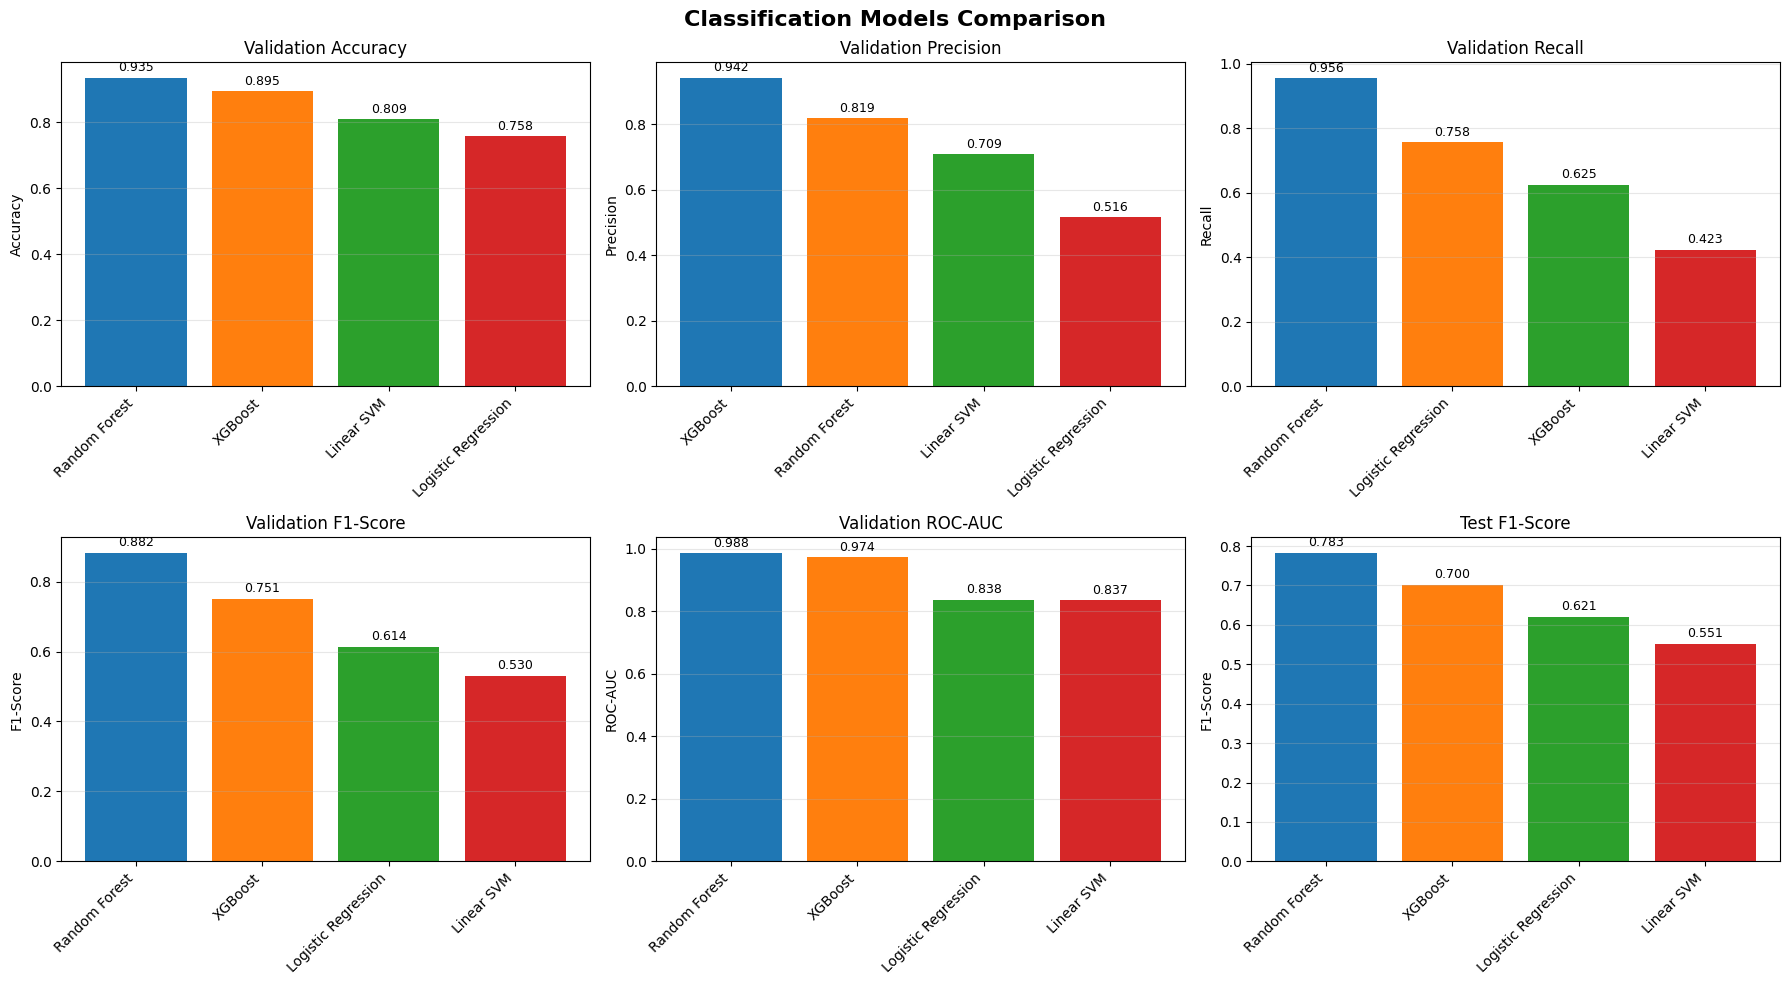

📊 Regression comparison chart saved: regression_comparison.png


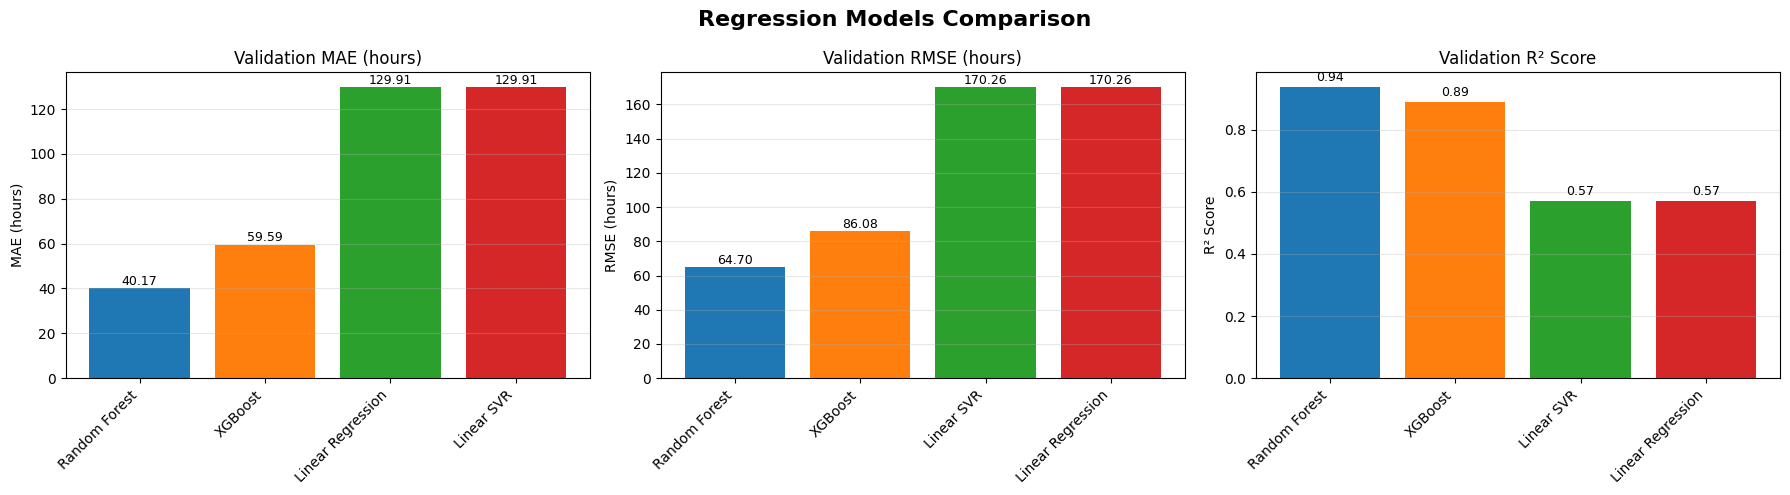


✅ ALL TASKS COMPLETED SUCCESSFULLY!


In [10]:
# ============================================================================
# FINAL SUMMARY & VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("🎉 MODEL TRAINING COMPLETED!")
print("="*80)

print(f"\n📁 Saved files:")
print("   Classification models:")
print("      - model_lr_classification.pkl")
print("      - model_svm_classification.pkl")
print("      - model_rf_classification.pkl")
print("      - model_xgb_classification.pkl")
print("      - classification_results.csv")

print("\n   Regression models:")
print("      - model_linreg_regression.pkl")
print("      - model_svr_regression.pkl")
print("      - model_rfr_regression.pkl")
print("      - model_xgbr_regression.pkl")
print("      - regression_results.csv")

print("\n   Other:")
print("      - scaler.pkl")

print(f"\n⏱️  Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ========== VISUALIZATION: CLASSIFICATION COMPARISON ==========
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Classification Models Comparison', fontsize=16, fontweight='bold')

metrics = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 3, idx % 3]
    data = results_df[metric].sort_values(ascending=False)
    bars = ax.bar(range(len(data)), data.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_ylabel(name)
    ax.set_title(f'Validation {name}')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, data.values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Test set comparison
ax = axes[1, 2]
test_f1 = results_df['test_f1'].sort_values(ascending=False)
bars = ax.bar(range(len(test_f1)), test_f1.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_xticks(range(len(test_f1)))
ax.set_xticklabels(test_f1.index, rotation=45, ha='right')
ax.set_ylabel('F1-Score')
ax.set_title('Test F1-Score')
ax.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, test_f1.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('classification_comparison.png', dpi=300, bbox_inches='tight')
print("\n📊 Classification comparison chart saved: classification_comparison.png")
plt.show()

# ========== VISUALIZATION: REGRESSION COMPARISON ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Regression Models Comparison', fontsize=16, fontweight='bold')

reg_metrics = ['val_mae', 'val_rmse', 'val_r2']
reg_names = ['MAE (hours)', 'RMSE (hours)', 'R² Score']

for idx, (metric, name) in enumerate(zip(reg_metrics, reg_names)):
    ax = axes[idx]
    data = reg_results_df[metric].sort_values(ascending=(metric != 'val_r2'))
    bars = ax.bar(range(len(data)), data.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.set_ylabel(name)
    ax.set_title(f'Validation {name}')
    ax.grid(axis='y', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, data.values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if metric != 'val_r2' else 0.01),
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('regression_comparison.png', dpi=300, bbox_inches='tight')
print("📊 Regression comparison chart saved: regression_comparison.png")
plt.show()

print("\n" + "="*80)
print("✅ ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*80)